
<a href="https://colab.research.google.com/drive/1wf_6lX7Ww5OPuMy1VqwsYbCyz1e1x8E3?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Global Average Pooling for Visualization


**Global Average Pooling layer:**   
- Both Average pooling and Max pooling layers operate on filter size. Average Pooling layer works similar to max pooling layer. However, instead of replacing entire areas with the maximum value, it replaces it with the average. 

- Global Average Pooling layer is similar to the Average Pooling layer however it takes the average over all values across the entire feature map (this why it is called global). For example, for in of 32x32x1024 the output is 1x1024.

**Fully Convolutional Networks:**

With fully connected (Dense) layers, it is impossible to have inputs of different size because it will not be compatible with the weight matrices. If all the layers are convolutional, then the number of filter weights is independent of the input image size. However, the the output shape depends on the input size in this case. The only layers that depend on the size of the input are the dense layers.

**Heatmaps:**
- In a classification scenario, if we design the network architecture so that the final convolution consists of filters equal to the number of classes, this will force the final convolutional filters to find out how each part of the image related to each class. Moreover, we can visualize the activations as a heatmap over the input image. 

- After this final convolution layer, global average pooling is applied across number of  convolution features equal to number of classes, which results in a vector of values that we can then use to classify the input image.

In [1]:
import keras
from keras.datasets import cifar10, mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [0]:
num_classes = 10
cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# The data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
input_shape = (32, 32, 3)
input_img = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(10, (3, 3), activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)
output_cls = Activation(activation='softmax')(x)

model = Model(input_img, output_cls)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0   

In [5]:
history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 15s 301us/step - loss: 1.5141 - accuracy: 0.4548 - val_loss: 2.1547 - val_accuracy: 0.3047
Epoch 2/40
50000/50000 [==============================] - 8s 168us/step - loss: 1.1741 - accuracy: 0.5822 - val_loss: 1.1764 - val_accuracy: 0.5784
Epoch 3/40
50000/50000 [==============================] - 8s 168us/step - loss: 1.0529 - accuracy: 0.6305 - val_loss: 1.1387 - val_accuracy: 0.5867
Epoch 4/40
50000/50000 [==============================] - 8s 168us/step - loss: 0.9768 - accuracy: 0.6571 - val_loss: 1.1486 - val_accuracy: 0.6108
Epoch 5/40
50000/50000 [==============================] - 8s 168us/step - loss: 0.9195 - accuracy: 0.6784 - val_loss: 1.0420 - val_accuracy: 0.6304
Epoch 6/40
50000/50000 [==============================] - 8s 168us/step - loss: 0.8771 - accuracy: 0.6926 - val_loss: 1.1432 - val_accuracy: 0.6047
Epoch 7/40
50000/50000 [==============================] - 8s 

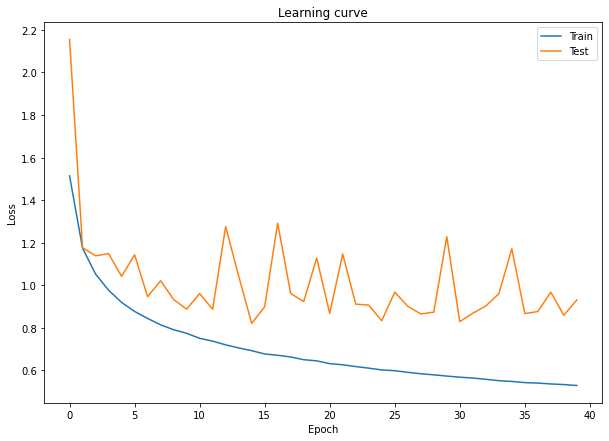

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')


plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

In [0]:
fmaps_fn = K.function(model.input, model.layers[-3].output)
props_fn = K.function(model.input, model.layers[-1].output)

In [0]:
def get_props_fmaps(inp):
    props = props_fn(inp)
    fmaps = fmaps_fn(inp)[0,:]
    return props, fmaps   

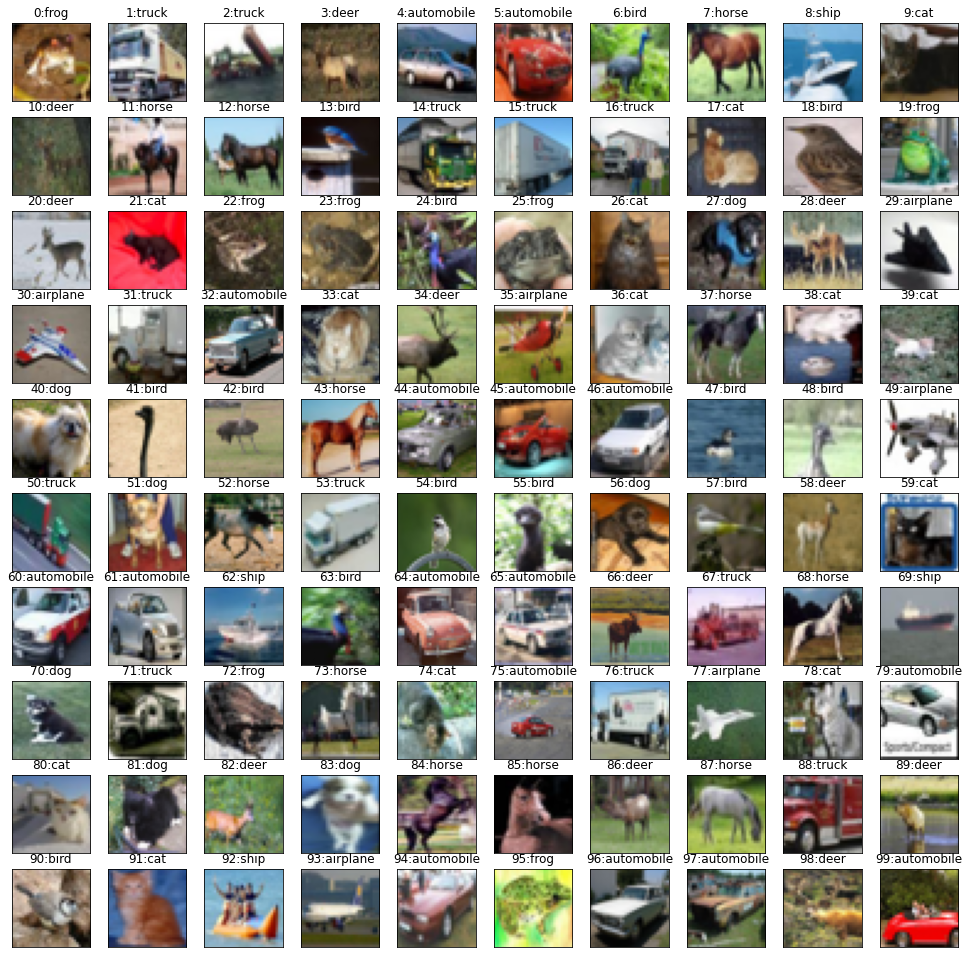

In [9]:
fig=plt.figure(figsize=(17, 17))
columns = 10
rows = 10
for i in range(rows * columns):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_train[i])
    plt.title(str(i)+ ":" + cls_names[np.argmax(y_train[i,:])])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

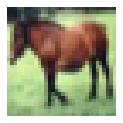

In [10]:
inp = x_train[7]
inp = np.expand_dims(inp, axis=0)
plt.figure(figsize=(2, 2))
ax = fig.add_subplot()
plt.imshow(inp.squeeze())
plt.axis('off')
plt.show()

7 horse


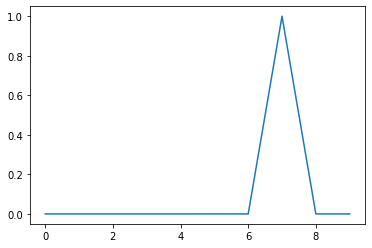

In [11]:
props, _ =  get_props_fmaps(inp)
print(np.argmax(props), cls_names[np.argmax(props)])
plt.plot(props.squeeze())

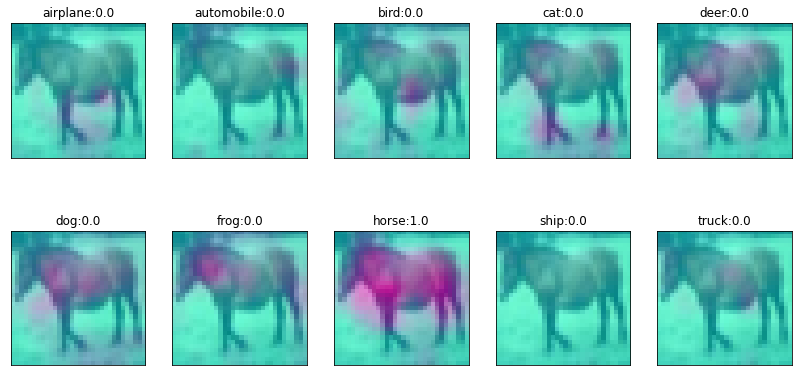

In [12]:
fig=plt.figure(figsize=(14, 7))
columns = 5
rows = 2

props, fmaps = get_props_fmaps(inp)
props = np.round(props.squeeze(),3)

for i in range(props.shape[0]):
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(inp.squeeze())
  overlay = np.array(Image.fromarray((fmaps[:,:,i]).astype("uint8")).resize((32,32)))
  plt.imshow(overlay, vmin=0.0, vmax=np.max(fmaps), cmap="cool", alpha=0.5)
  plt.title(cls_names[i] + ":"+ str(props[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # plt.colorbar()
plt.show()